# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import* #Using new hydromet_stratified

### Parameters: 

#### Papermill (site specific):

In [21]:

## Filenames and fields:
Project_Area = 'DesPlaines'          # Project area name
Pluvial_Model = 'P03'                # Pluvial model name
BCN = '01070005'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'Concord_domain_spc.shp'           # Shapefile name
filter_field = 'HUC_8'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = BCN                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [16]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [17]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['24h'  ] #'05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h' ,'04d'
dur_names = ['24hr' ]  # '5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr',  '96hr'

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [20]:
gdf = gpd.read_file(polygon_dir)

check_attributes(gdf)

gdf.head(1)

,OBJECTID_1,OBJECTID,Gaz_ID,Area_Acres,Area_SqKm,States,LoadDate,HUC_8,HU_8_Name,GlobalID,Shape_STAr,Shape_STLe,Shape_Leng,HUC4,Shape_Le_1,Shape_Area,geometry
0,1,32,0,256173.721662,1036.702418,MA,2012-06-06,01070005,Concord,{26B4D3FA-C10D-496C-A33D-C960BE6DE84D},0.113352,2.185344,2.185344,0107,686281.665826,1.115830e+10,"POLYGON ((711705.302 3058725.635, 711828.474 3..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [22]:
print('Original Coordinate Reference System:', gdf.crs)

with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Original Coordinate Reference System: PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",41],PARAMETER["central_meridian",-71.5],PARAMETER["standard_parallel_1",41.7166666666667],PARAMETER["standard_parallel_2",42.6833333333333],PARAMETER["false_easting",656166.666666667],PARAMETER["false_northing",2460625],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Vector Layer crs = +proj=lcc +lat_0=41 +lon_0=-71.5 +lat_1=41.7166666666667 +lat_2=42.6833333333333 +x_0=200000 +y_0=750000 +datum=NAD83 +units=us-ft +no_defs


### Extract the area of interest, reproject, and plot:

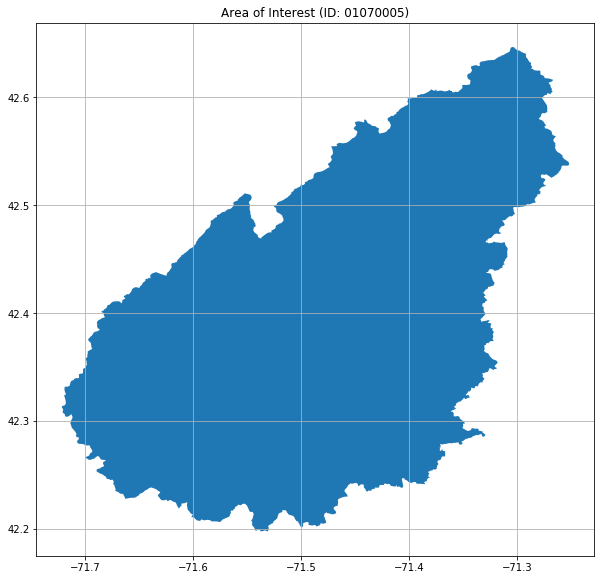

In [23]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj
    
geo_df = gdf1.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           10
Region           2
Percent_area     100.0


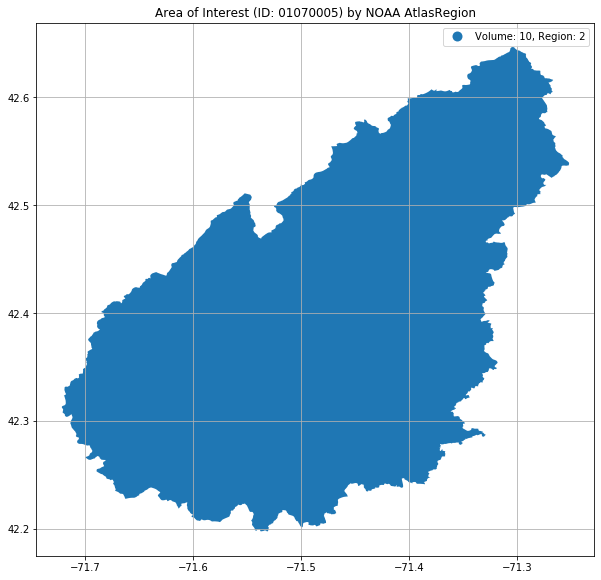

In [24]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [25]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: ne


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [26]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

#Added by Mark Bartlett 
#Parse out the file name by using split functions
for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

30 files found for 24h


### Iterate through zip files and build a table:

In [27]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 ne1yr24ha.zip
1 ne1yr24hal.zip
2 ne1yr24hau.zip
3 ne2yr24ha.zip
4 ne2yr24hal.zip
5 ne2yr24hau.zip
6 ne5yr24ha.zip
7 ne5yr24hal.zip
8 ne5yr24hau.zip
9 ne10yr24ha.zip
10 ne10yr24hal.zip
11 ne10yr24hau.zip
12 ne25yr24ha.zip
13 ne25yr24hal.zip
14 ne25yr24hau.zip
15 ne50yr24ha.zip
16 ne50yr24hal.zip
17 ne50yr24hau.zip
18 ne100yr24ha.zip
19 ne100yr24hal.zip
20 ne100yr24hau.zip
21 ne200yr24ha.zip
22 ne200yr24hal.zip
23 ne200yr24hau.zip
24 ne500yr24ha.zip
25 ne500yr24hal.zip
26 ne500yr24hau.zip
27 ne1000yr24ha.zip
28 ne1000yr24hal.zip
29 ne1000yr24hau.zip
28 Seconds


,region,TR,duration,statistic,value
0,ne,1,24h,Expected Value,2.669244
1,ne,1,24h,Lower (90%),2.140739
2,ne,1,24h,Upper (90%),3.279545
3,ne,2,24h,Expected Value,3.269051
4,ne,2,24h,Lower (90%),2.618799


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [28]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

In [29]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           2.669244     2.140739     3.279545
2           3.269051     2.618799     4.020598
5           4.249757     3.392219     5.243687
10          5.063368     4.017082     6.281425
25          6.183249     4.755345     8.052542
50          7.009970     5.286192     9.343607
100         7.909753     5.810667    10.991487
200         9.012390     6.171392    12.624631
500        10.708725     7.040440    15.507572
1000       12.170391     7.811445    17.953191

NOAA_Atlas_MetaData:


,Volume,Region,Percent_area
AOI,,,
HUC_8_01070005,10,2,100.0


---